# Import libraries

In [1]:
import os
from os import path

import glob
import pandas as pd
import numpy as np
import wget
from github import Github
import shutil

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

import tensorflow as tf

# signal processing
from scipy import signal
from scipy.ndimage import label as sci_label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from numpy import trapz

# misc
import warnings

Set and clear output directories

In [8]:
# remove all existing csv files
! del *.csv
! del *.xlsx


if path.exists('C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\\Raw Data') == True:
  shutil.rmtree("C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\\Raw Data")

if path.exists('C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\\Raw Data\\Multimodal\\ECG\\') == False:
  os.mkdir('C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\\Raw Data')
  os.mkdir('C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\\Raw Data\\Multimodal')
  os.mkdir('C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\\Raw Data\\Multimodal\\ECG')
  


if path.exists('C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\\Raw Data\\Single Modal\\ECG') == False:
  os.mkdir('C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\\Raw Data\\Single Modal')
  os.mkdir('C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\\Raw Data\\Single Modal\\ECG')

!cd
!dir

Could Not Find c:\Users\ferri\Downloads\PoliTO\Tesi\Repos\ECG-Stress-Detection\YAAD\*.xlsx


c:\Users\ferri\Downloads\PoliTO\Tesi\Repos\ECG-Stress-Detection\YAAD
 Volume in drive C is Windows-SSD
 Volume Serial Number is 7CB9-87CF

 Directory of c:\Users\ferri\Downloads\PoliTO\Tesi\Repos\ECG-Stress-Detection\YAAD

05/06/2025  12:46 PM    <DIR>          .
05/02/2025  12:09 PM    <DIR>          ..
01/10/2025  05:55 PM         2,456,237 2022 YAAD_Young_Adults_Affective_Data_Using_Wearable_ECG_and_GSR_sensors.pdf
02/13/2025  01:32 PM         1,575,841 ecg-emotion-recognition.ipynb
04/25/2025  03:04 PM           181,820 YAAD_feats-fusion-selection_class-bal.ipynb
               3 File(s)      4,213,898 bytes
               2 Dir(s)  835,871,531,008 bytes free


# Retrieve datasets

Read xlsx files and convert to csv and transform into datafram for processing

In [9]:
stimulus_desc_file = pd.read_excel('C:\\Users\\ferri\\Downloads\\PoliTO\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\\Stimulus_Description.xlsx')
stimulus_desc_file.to_csv('Stimulus_Description.csv', index = None, header=True)
stimulus_desc = pd.read_csv('Stimulus_Description.csv')
#stimulus_desc.head()

In [10]:
self_annotation_multimodal_file = pd.read_excel('C:\\Users\\ferri\\Downloads\\PoliTO\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\\Self-Annotation Labels\\Self-annotation Multimodal_Use.xlsx')
self_annotation_multimodal_file.to_csv('Self-annotation Multimodal_Use.csv', index = None, header=True)
self_annotation_multimodal = pd.read_csv('Self-annotation Multimodal_Use.csv')
self_annotation_multimodal['annotation'] = 'M'
self_annotation_multimodal.rename(columns = {'V_Label':'Valence', 'A_Label':'Arousal', 'Four_Labels':'Four_Label'}, inplace = True)
#self_annotation_multimodal.head()

In [11]:
self_annotation_singlemodal_file = pd.read_excel('C:\\Users\\ferri\\Downloads\\PoliTO\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\\Self-Annotation Labels\\Self-annotation Single Modal_Use.xlsx')
self_annotation_singlemodal_file.to_csv('Self-annotation Single Modal_Use.csv', index = None, header=True)
self_annotation_singlemodal = pd.read_csv('Self-annotation Single Modal_Use.csv')
self_annotation_singlemodal['annotation'] = 'S'
self_annotation_singlemodal.rename(columns = {'Male':'Gender', 'Session Id':'Session ID', 'Video Id':'Video ID'}, inplace = True)
#self_annotation_singlemodal.head()

In [12]:
self_annotation_frames = [self_annotation_multimodal, self_annotation_singlemodal]
merged_dataframe = pd.concat(self_annotation_frames)
#merged_dataframe.head()
#merged_dataframe.tail()
table_frame = merged_dataframe.copy()

In [13]:
cols = []
cols.append('Raw Data')
for col in merged_dataframe.columns:
    cols.append(col)

# Data processing

Processed data: Collected ECG signals are converted into numerical series data values.

In [ ]:
arr_shape = 1000
raw_data_arr = []

def form_data(data_array=[], annotation='', data_path=''):
    print(f"Processing data for annotation '{annotation}' from path: {data_path}")
    if not os.path.exists(data_path):
        print(f"Data path does not exist: {data_path}")
        return data_array

    files_in_directory = os.listdir(data_path)
    if not files_in_directory:
        print(f"No files found in directory: {data_path}. Ensure .dat files are present.")
        return data_array
    
    print(f"Found files: {files_in_directory[:5]} ... (total {len(files_in_directory)})")

    for filename in files_in_directory:
        if not filename.endswith('.dat'):
            continue
        
        try:
            file_path = os.path.join(data_path, filename)
            ecg_signal_data = np.loadtxt(file_path, delimiter=',')[:arr_shape]

            # parse S, P, V from name “ECGdata_s{S}p{P}v{V}.dat”
            if not filename.startswith('ECGdata_') or not filename.endswith('.dat'):
                continue
            parts = filename.replace('ECGdata_','').replace('.dat','').lower()
            s_str, p_str, v_str = None, None, None
            temp = parts.split('s')
            if len(temp)>1:
                s_and_rest = temp[1]
                s_str, rest = s_and_rest.split('p',1)
                p_str, v_str = rest.split('v',1)

            session_id = int(s_str); participant_id = int(p_str); video_id = int(v_str)

        except Exception as e:
            print(f"Skipping {filename}: {e}")
            continue

        # lookup annotation row
        data_row_df = merged_dataframe.loc[
            (merged_dataframe['Session ID']==session_id)&
            (merged_dataframe['Participant Id']==participant_id)&
            (merged_dataframe['Video ID']==video_id)&
            (merged_dataframe['annotation']==annotation)
        ]
        stim_row_df = stimulus_desc.loc[
            (stimulus_desc['Session ID']==session_id)&
            (stimulus_desc['Video ID']==video_id)
        ]

        if data_row_df.empty or stim_row_df.empty:
            continue

        target_emotion_val = stim_row_df['Target Emotion'].iat[0]
        for _, row_data in data_row_df.iterrows():
            data_array.append([
                ecg_signal_data,                    # 1
                row_data['Participant Id'],         # 2
                row_data['Session ID'],             # 3
                row_data['Video ID'],               # 4
                row_data['Name'],                   # 5
                row_data['Age'],                    # 6
                row_data['Gender'],                 # 7
                row_data['Valence level'],          # 8
                row_data['Arousal level'],          # 9
                row_data['Dominance level'],        # 10
                row_data['Happy'],                  # 11
                row_data['Sad'],                    # 12
                row_data['Fear'],                   # 13
                row_data['Anger'],                  # 14
                row_data['Neutral'],                # 15
                row_data['Disgust'],                # 16
                row_data['Surprised'],              # 17
                row_data['Familiarity Score'],      # 18
                row_data['Emotion'],                # 19
                row_data['Valence'],                # 20
                row_data['Arousal'],                # 21
                row_data['Four_Label'],             # 22
                row_data['annotation'],             # 23
                target_emotion_val                  # 24
            ])

    return data_array

# run both annotations
raw_data_arr = form_data(raw_data_arr, 'M',
    r"C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\ECG_GSR_Emotions\Raw Data\Multimodal\ECG\")
raw_data_arr = form_data(raw_data_arr, 'S',
    r"C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\ECG_GSR_Emotions\Raw Data\Single Modal\ECG\")

# explicit 24-column list
cols = [
    'Raw Data',
    'Participant Id',
    'Session ID',
    'Video ID',
    'Name',
    'Age',
    'Gender',
    'Valence level',
    'Arousal level',
    'Dominance level',
    'Happy',
    'Sad',
    'Fear',
    'Anger',
    'Neutral',
    'Disgust',
    'Surprised',
    'Familiarity Score',
    'Emotion',
    'Valence',
    'Arousal',
    'Four_Label',
    'annotation',
    'Target Emotion'
]

raw_dataframe = pd.DataFrame(raw_data_arr, columns=cols)
raw_dataframe.rename(columns={
    'Participant Id':'Participant ID',
    'Four_Label':'Four label',
    'annotation':'Modal'
}, inplace=True)
raw_dataframe['Familiarity Score'] = raw_dataframe['Familiarity Score'].fillna('Never watched')
raw_dataframe.replace(np.nan, '', regex=True, inplace=True)

raw_dataframe.head()


Processing data for annotation 'M' from path: C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\ECG_GSR_Emotions\Raw Data\Multimodal\ECG\
Found files: ['ECGdata_s1p10v1.dat', 'ECGdata_s1p10v2.dat', 'ECGdata_s1p10v3.dat', 'ECGdata_s1p10v4.dat', 'ECGdata_s1p10v5.dat'] ... (total 252)
Processing data for annotation 'S' from path: C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\ECG_GSR_Emotions\Raw Data\Single Modal\ECG\
Found files: ['ECGdata_s1p10v1.dat', 'ECGdata_s1p10v2.dat', 'ECGdata_s1p10v3.dat', 'ECGdata_s1p10v4.dat', 'ECGdata_s1p10v5.dat'] ... (total 154)


ValueError: 26 columns passed, passed data had 24 columns

# Data visualization

Using Matplotlib, we can visualized the data/signals per emotion into signal waves

In [33]:
plot_frame = raw_dataframe.copy()
plot_frame.head()

,Raw Data,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four label,Modal,Target Emotion
0,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,1,1,S_D,8,Male,8,3,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M,happy
1,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,1,1,S_D,8,Male,9,7,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,HA,HVHA,M,happy
2,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",10,1,2,S_D,8,Male,5,4,2,...,Low,VeryLow,Low,Never watched,Mixed,LV,LA,LVLA,M,sad
3,"[-18.705, -18.669, -18.642, -18.586, -18.552, ...",10,1,3,S_D,8,Male,4,0,0,...,VeryHigh,VeryLow,VeryLow,Never watched,Neutral,LV,LA,LVLA,M,neutral
4,"[-18.561, -18.561, -18.557, -18.557, -18.545, ...",10,1,4,S_D,8,Male,7,6,0,...,VeryLow,VeryLow,VeryHigh,Never watched,Surprise,HV,HA,HVHA,M,surprise


In [34]:
plot_frame = plot_frame.drop(['Participant ID', 'Session ID', 'Familiarity Score', 'Age', 'Gender', 'Name'], axis = 1)
sad_data = plot_frame.loc[(plot_frame['Emotion'] == 'Sad') & (plot_frame['Target Emotion'] == 'sad')] 
fear_data = plot_frame.loc[(plot_frame['Emotion'] == 'Fear')  & (plot_frame['Target Emotion'] == 'fear')]
happy_data = plot_frame.loc[(plot_frame['Emotion'] == 'Happy') & (plot_frame['Target Emotion'] == 'happy')]
anger_data = plot_frame.loc[(plot_frame['Emotion'] == 'Anger') & (plot_frame['Target Emotion'] == 'anger')]
neutral_data = plot_frame.loc[(plot_frame['Emotion'] == 'Neutral') & (plot_frame['Target Emotion'] == 'neutral')]
mixed_data = plot_frame.loc[(plot_frame['Emotion'] == 'Mixed') & (plot_frame['Target Emotion'] == 'neutral')]
disgust_data = plot_frame.loc[(plot_frame['Emotion'] == 'Disgust') & (plot_frame['Target Emotion'] == 'disgust')]
surprised_data = plot_frame.loc[(plot_frame['Emotion'] == 'Surprise') & (plot_frame['Target Emotion'] == 'surprise')]

In [35]:
def plot_signals(data_arr, title = ''):
    plt.clf()
    plt.figure(figsize=(12, 4))
    
    for index, row in data_arr.iterrows():
        y = row['Raw Data']
        plt.plot(y)
        #x = np.arange(y.size)
        #plt.plot(x, y)
    
    plt.tight_layout()
    plt.title(title)
    plt.show()

**SAD**

<Figure size 640x480 with 0 Axes>

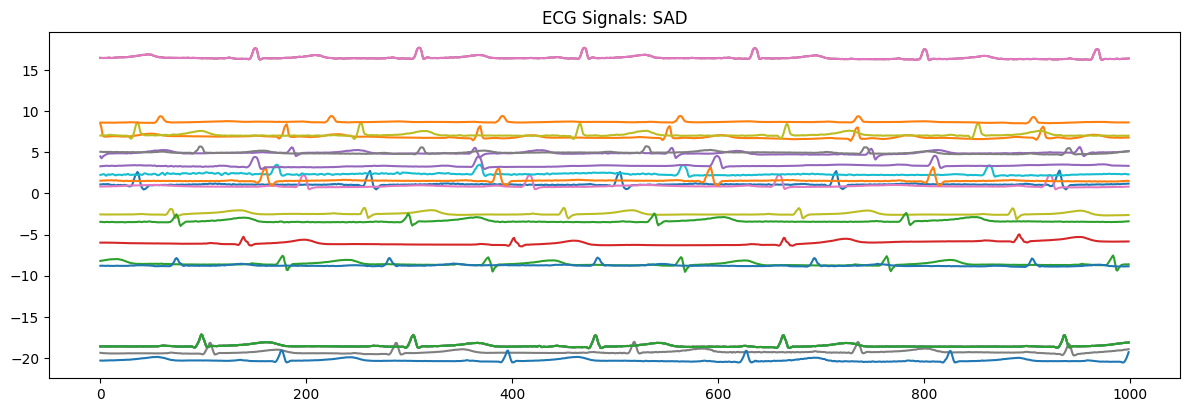

In [36]:
plot_signals(data_arr = sad_data, title = 'ECG Signals: SAD')

**FEAR**

<Figure size 640x480 with 0 Axes>

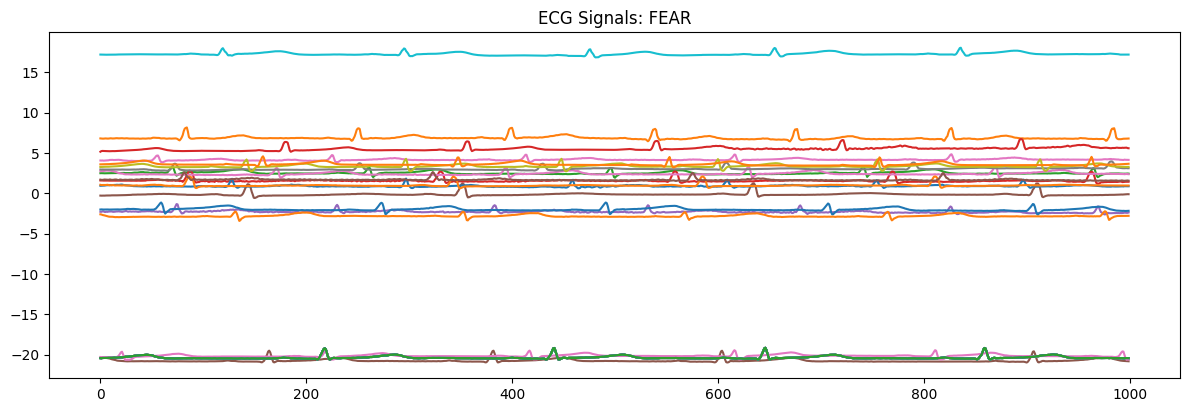

In [37]:
plot_signals(data_arr = fear_data, title = 'ECG Signals: FEAR')

**HAPPY**: Signals scatters on different levels

<Figure size 640x480 with 0 Axes>

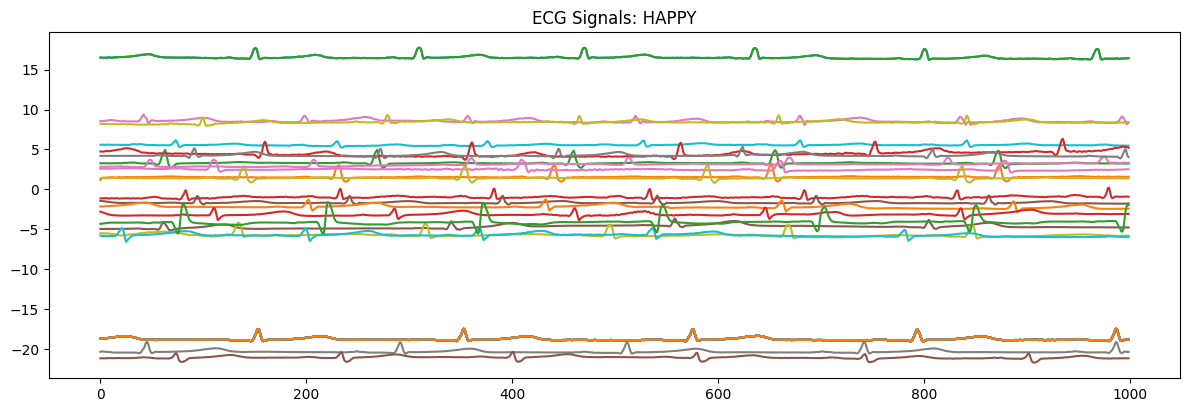

In [38]:
plot_signals(data_arr = happy_data, title = 'ECG Signals: HAPPY')

**ANGER**: Signals scatters on different levels

<Figure size 640x480 with 0 Axes>

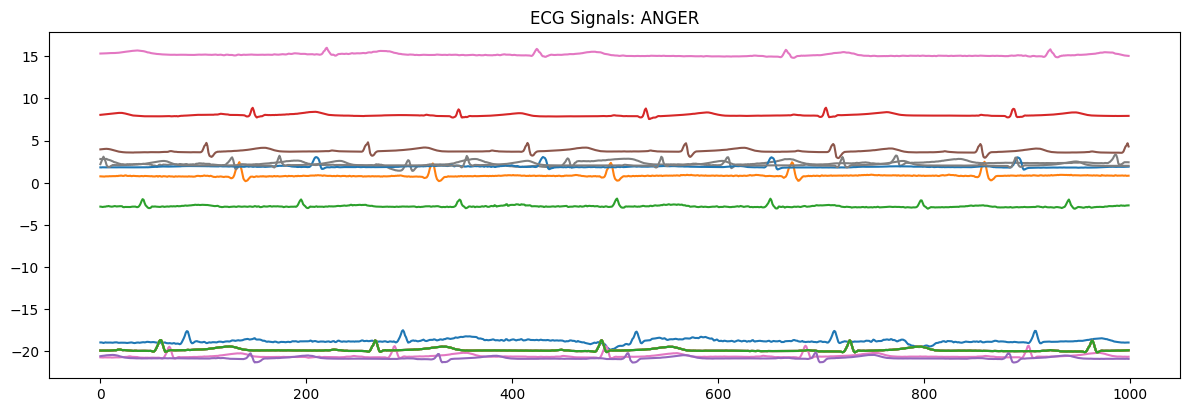

In [39]:
plot_signals(data_arr = anger_data, title = 'ECG Signals: ANGER')

**NEUTRAL**: Signals above 0 region are scatterd. Some are on -15 to -20 area

<Figure size 640x480 with 0 Axes>

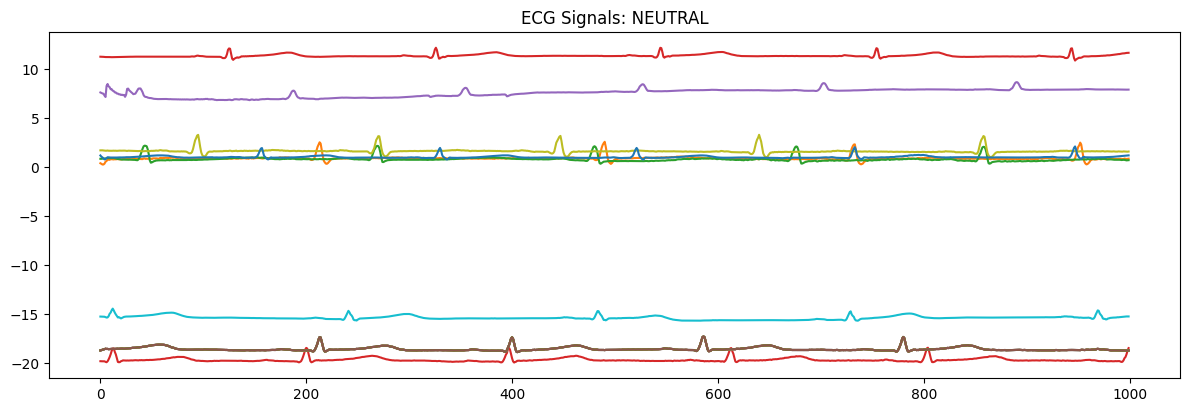

In [40]:
plot_signals(data_arr = neutral_data, title = 'ECG Signals: NEUTRAL')

**MIXED**: Most signals resides on zero level

<Figure size 640x480 with 0 Axes>

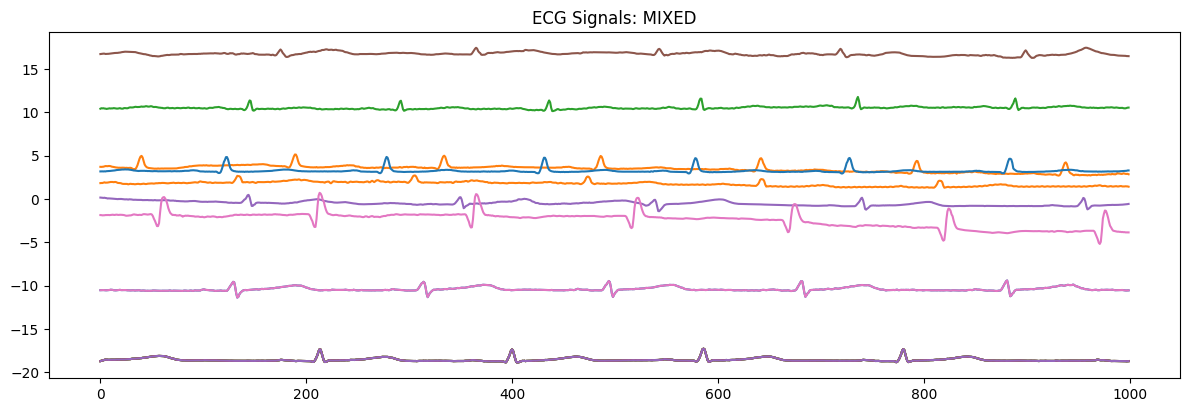

In [41]:
plot_signals(data_arr = mixed_data, title = 'ECG Signals: MIXED')

**DISGUST** : Signals are on 0-5 region and a lot on -20 level

<Figure size 640x480 with 0 Axes>

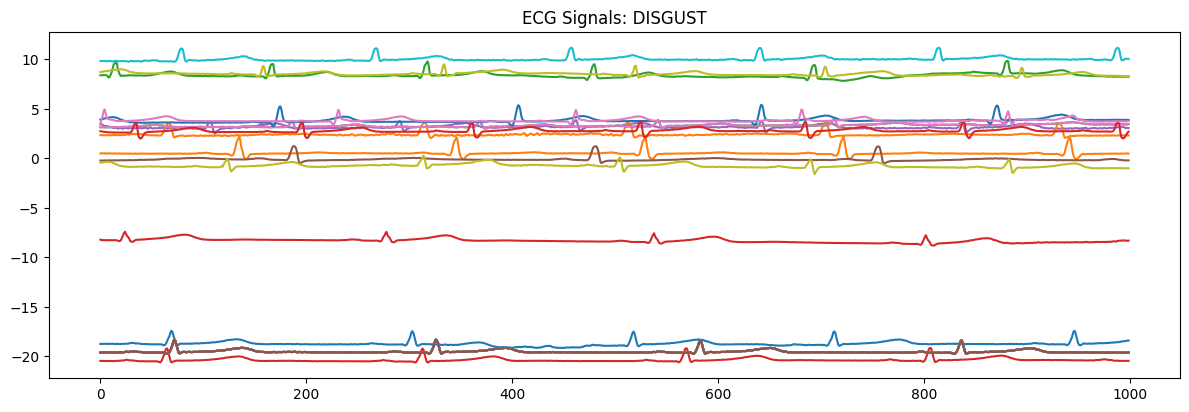

In [42]:
plot_signals(data_arr = disgust_data, title = 'ECG Signals: DISGUST')

**SURPRISED** : signals are all similar and residing near zero region

<Figure size 640x480 with 0 Axes>

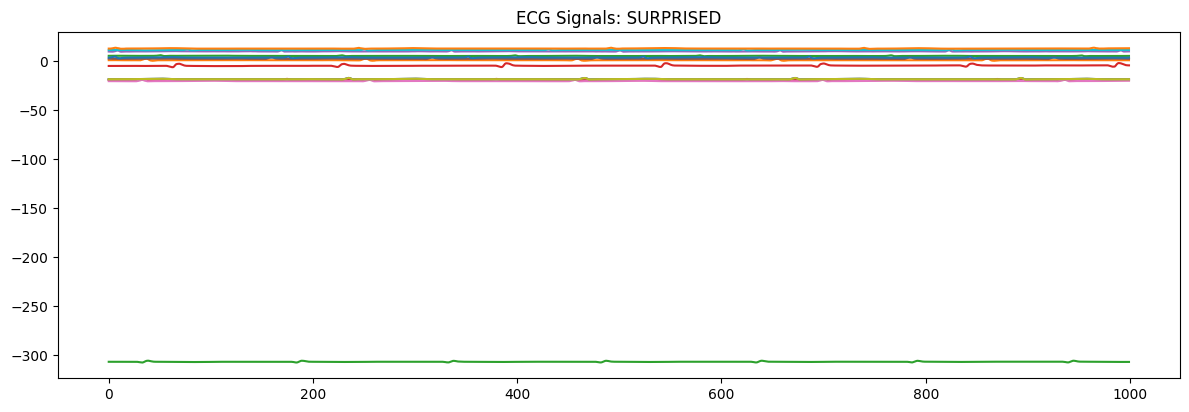

In [43]:
plot_signals(data_arr = surprised_data, title = 'ECG Signals: SURPRISED')

**Findings:** Uncertain on possible recognized pattern based on visual representation of the data

# Model creation and training

In [44]:
#train_d_frame = plot_frame.copy().drop(['Video ID', 'Valence level', 'Arousal level',
#                                        'Dominance level', 'Happy', 'Sad', 'Fear',
#                                        'Anger', 'Neutral', 'Disgust', 'Surprised',
#                                        'Valence', 'Arousal', 'Four label', 'Modal'
#                                       ], axis = 1)
train_d_frame = plot_frame.copy().drop(['Video ID', 'Happy', 'Sad', 'Fear',
                                        'Anger', 'Neutral', 'Disgust', 'Surprised', 'Four label', 'Modal'
                                       ], axis = 1)
train_d_frame.rename(columns = {'Raw Data':'feature', 'Emotion':'emotion'}, inplace = True)
train_d_frame.head()


,feature,Valence level,Arousal level,Dominance level,emotion,Valence,Arousal,Target Emotion
0,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",8,3,0,Happy,HV,LA,happy
1,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",9,7,0,Happy,HV,HA,happy
2,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",5,4,2,Mixed,LV,LA,sad
3,"[-18.705, -18.669, -18.642, -18.586, -18.552, ...",4,0,0,Neutral,LV,LA,neutral
4,"[-18.561, -18.561, -18.557, -18.557, -18.545, ...",7,6,0,Surprise,HV,HA,surprise


In [45]:
x = np.array(train_d_frame['feature'].tolist())
y = np.array(train_d_frame['emotion'].tolist())

In [46]:
sc = StandardScaler()
x = sc.fit_transform(x)

In [47]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

Split the dataset into training and testing dataset

In [48]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0) # (TAMBAHAN/EDITED)

In [49]:
num_labels = y.shape[1]
num_labels

8

In [50]:
arr_shape

1000

Create model

In [51]:
# TAMBAHAN/EDITED - activation dari hidden layer sebelumnya adalah relu

model = Sequential()

##first layer
model.add(Dense(1, input_shape = (arr_shape,)))
model.add(Activation('sigmoid'))  # (TAMBAHAN/EDITED)

##second layer
model.add(Dense(2))
model.add(Activation('sigmoid'))  # (TAMBAHAN/EDITED)

##third layer
model.add(Dense(4))
model.add(Activation('sigmoid'))  # (TAMBAHAN/EDITED)

##fourth layer
model.add(Dense(8))
model.add(Activation('sigmoid'))  # (TAMBAHAN/EDITED)

##final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,129 (4.41 KB)

 Trainable params: 1,129 (4.41 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'RMSProp') #TAMBAHAN/EDITED

In [57]:
num_epochs = 15 # (TAMBAHAN/EDITED)
num_batch_size = 3 # (TAMBAHAN/EDITED)

checkpointer = ModelCheckpoint(filepath = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\\Raw Data\\ecg_emotion_recognizer.keras', 
                              verbose = 1, save_best_only = True)

start = datetime.now()

model.fit(x_train, y_train, batch_size = num_batch_size, epochs = num_epochs,
         validation_data = (x_test, y_test), callbacks = [checkpointer], verbose = 1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/15
50/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1128 - loss: 2.2139       
Epoch 1: val_loss improved from inf to 2.15282, saving model to C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\ECG_GSR_Emotions\Raw Data\ecg_emotion_recognizer.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1024 - loss: 2.2056 - val_accuracy: 0.0500 - val_loss: 2.1528
Epoch 2/15
50/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0881 - loss: 2.1276     
Epoch 2: val_loss improved from 2.15282 to 2.06469, saving model to C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\ECG_GSR_Emotions\Raw Data\ecg_emotion_recognizer.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0889 - loss: 2.1063 - val_accuracy: 0.2083 - val_loss: 2.0647
Epoch 3/15
61/93 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.1371 - loss: 2.0574   
Epoch 3: val_loss improved from 2.06469 to 2.01719, saving model to C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\ECG_GSR_Emotions\Raw Da

# Model accuracy

In [58]:
test_accuracy = model.evaluate(x_test, y_test, verbose = 0)
print(test_accuracy)

[1.9598981142044067, 0.2750000059604645]


# Initial Findings

**Initial Findings**: Model displayed low accuracy. Need to look for possible improvements. Will try feature extraction on raw data signals.

In [59]:
from __future__ import division
from matplotlib import pyplot as plt
import scipy.io as spio
import numpy as np
import statistics
from scipy.stats import kurtosis
from scipy.stats import skew
import sys
#sys.path.append("/home/chandan/python-workspace/")
# import BOCPD as ocpd #import bocpd from another file
import cProfile
from functools import partial

In [60]:

## Reference: https://github.com/chandanacharya1/ECG-Feature-extraction-using-Python/blob/master/features.py
####################### FEATURE DEFINITIONS ###################################


def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = sci_label(np.diff(p) < threshold)
 
    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
    #for i in np.unique(peak_groups):    
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

"""TIME DOMAIN"""
#independent function to calculate RMSSD
def calc_rmssd(list):
    diff_nni = np.diff(list)#successive differences
    return np.sqrt(np.mean(diff_nni ** 2))
    
    
 #independent function to calculate AVRR   
def calc_avrr(list):
    return sum(list)/len(list)

 #independent function to calculate SDRR   
def calc_sdrr(list):
    return statistics.stdev(list)

 #independent function to calculate SKEW   
def calc_skew(list):
    return skew(list)

 #independent function to calculate KURT   
def calc_kurt(list):
    return kurtosis(list)

def calc_NNx(list):
    #diff_nni = np.diff(list)
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    nnxx = np.sum(np.abs(np.diff(rr)) > 50)*1
    #return sum(np.abs(diff_nni) > 50)
    return nnxx
    
def calc_pNNx(list):
    #length_int = len(list)
    #diff_nni = np.diff(list)
    #nni_50 = sum(np.abs(diff_nni) > 50)
    #return 100 * nni_50 / length_int
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    pnnxx = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    #return sum(np.abs(diff_nni) > 50)
    return pnnxx
    
"""NON LINEAR DOMAIN"""
 #independent function to calculate SD1
def calc_SD1(list):
    diff_nn_intervals = np.diff(list)
    return np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
 #independent function to calculate SD2
def calc_SD2(list):
    diff_nn_intervals = np.diff(list)
    return np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                   diff_nn_intervals, ddof=1) ** 2)
    
 #independent function to calculate SD1/SD2
def calc_SD1overSD2(list):
      diff_nn_intervals = np.diff(list)
      sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
      sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                    diff_nn_intervals, ddof=1) ** 2)
      ratio_sd2_sd1 = sd2 / sd1
      return ratio_sd2_sd1
    
    
 #independent function to calculate CSI
def calc_CSI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return L/T
       
 #independent function to calculate CVI
def calc_CVI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return np.log10(L * T)
 
 #independent function to calculate modified CVI
def calc_modifiedCVI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return L ** 2 / T


def calc_meanrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.mean(rr)

def calc_medianrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.median(rr)

    
def calc_hr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    hr = 60000/rr
    return np.mean(hr) 

    

In [61]:
extract_frame = train_d_frame.copy()
#hrv_data = train_d_frame.copy()

medianrr = []
meanrr = []
rmssd = []
sdrr_rmssd = []
hr = []
avrr = []
sdrr = []
skew_ = []
kurt = []
NNx = []
pNNx = []
SD1 = []
SD2 = []
CSI = []
CVI = []
modifiedCVI = []
SD1overSD2 = []
for index, row in extract_frame.iterrows():
    rmssd.append(calc_rmssd(row['feature']))
    avrr.append(calc_avrr(row['feature']))
    sdrr.append(calc_sdrr(row['feature']))
    skew_.append(calc_skew(row['feature']))
    kurt.append(calc_kurt(row['feature']))
    NNx.append(calc_NNx(pd.Series(row['feature'])))
    pNNx.append(calc_pNNx(pd.Series(row['feature'])))
    SD1.append(calc_SD1(row['feature']))
    SD2.append(calc_SD2(row['feature']))
    CSI.append(calc_CSI(row['feature']))
    CVI.append(calc_CVI(row['feature']))
    modifiedCVI.append(calc_modifiedCVI(row['feature']))
    SD1overSD2.append(calc_SD1overSD2(row['feature']))
    meanrr.append(calc_meanrr(pd.Series(row['feature'])))
    medianrr.append(calc_medianrr(pd.Series(row['feature'])))
    hr.append(calc_hr(pd.Series(row['feature'])))
    sdrrrmssd = calc_sdrr(row['feature']) / calc_rmssd(row['feature'])
    sdrr_rmssd.append(sdrrrmssd)
    

extract_frame['meanrr'] = meanrr
extract_frame['medianrr'] = medianrr
extract_frame['sdrr'] = sdrr
extract_frame['rmssd'] = rmssd
extract_frame['sdrr_rmssd'] = sdrr_rmssd
extract_frame['hr'] = hr
extract_frame['NNx'] = NNx
extract_frame['pNNx'] = pNNx
extract_frame['sd1'] = SD1
extract_frame['sd2'] = SD2
extract_frame['avrr'] = avrr
extract_frame['skew'] = skew_
extract_frame['kurt'] = kurt
extract_frame['avrr'] = avrr
extract_frame['csi'] = CSI
extract_frame['cvi'] = CVI
extract_frame['modifiedcvi'] = modifiedCVI

extract_frame = extract_frame.drop(['Valence level', 'Arousal level', 'Dominance level'], axis = 1)
extract_frame2 = extract_frame.copy()
extract_frame = extract_frame.drop(['feature', 'Target Emotion'], axis = 1)
extract_frame = extract_frame.drop(['Valence', 'Arousal'], axis = 1)
extract_frame = extract_frame.drop(['avrr', 'csi', 'cvi', 'modifiedcvi'], axis = 1)
extract_frame.head()

,emotion,meanrr,medianrr,sdrr,rmssd,sdrr_rmssd,hr,NNx,pNNx,sd1,sd2,skew,kurt
0,Happy,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,3.058683,12.166933
1,Happy,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,3.058683,12.166933
2,Mixed,209.625,194.25,0.221027,0.072777,3.037027,294.650732,1,25.0,0.051486,0.308310,3.158817,12.848869
3,Neutral,189.000,186.50,0.205307,0.064151,3.200358,317.593251,0,0.0,0.045385,0.286779,2.862825,11.344312
4,Surprise,219.500,221.50,0.197991,0.062261,3.180001,273.960919,0,0.0,0.044048,0.276516,2.842292,11.033996


In [62]:
from sklearn import preprocessing
import seaborn as sns

In [63]:
#extract_frame = extract_frame2.drop(['feature'], axis = 1)
#extract_frame = extract_frame2.drop(['Target Emotion'], axis = 1)
le = preprocessing.LabelEncoder()
le.fit(extract_frame['emotion'])
extract_frame['emotion'] = le.transform(extract_frame['emotion'])


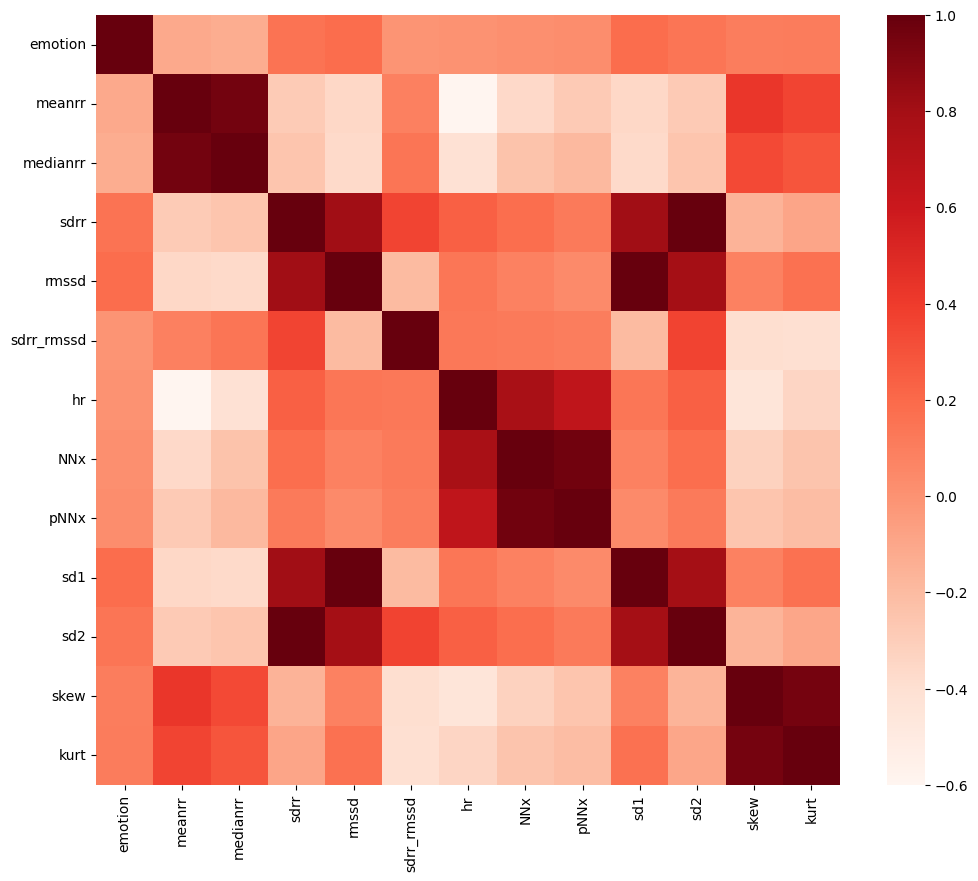

In [64]:
plt.figure(figsize=(12,10))
corr = extract_frame.corr()
sns.heatmap(corr, annot=False, cmap=plt.cm.Reds)
plt.show()

In [65]:
def feature_selection(correlation, threshold):
    selected_features = []
    for i in range(corr.shape[0]):
      if corr.iloc[i,0] > threshold:
        selected_features.append(extract_frame.iloc[:,i])
    return pd.DataFrame(selected_features).T

In [66]:
extract_frame.head()

,emotion,meanrr,medianrr,sdrr,rmssd,sdrr_rmssd,hr,NNx,pNNx,sd1,sd2,skew,kurt
0,3,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,3.058683,12.166933
1,3,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,3.058683,12.166933
2,4,209.625,194.25,0.221027,0.072777,3.037027,294.650732,1,25.0,0.051486,0.308310,3.158817,12.848869
3,5,189.000,186.50,0.205307,0.064151,3.200358,317.593251,0,0.0,0.045385,0.286779,2.862825,11.344312
4,7,219.500,221.50,0.197991,0.062261,3.180001,273.960919,0,0.0,0.044048,0.276516,2.842292,11.033996


In [67]:
# CORRELATION_THRESHOLD = 0.1
# extract_frame = feature_selection(extract_frame, CORRELATION_THRESHOLD)
x = extract_frame.drop(['emotion'],axis=1)
y = extract_frame['emotion']
# train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=0)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=0) # TAMBAHAN/EDITED

extract_frame.head()

,emotion,meanrr,medianrr,sdrr,rmssd,sdrr_rmssd,hr,NNx,pNNx,sd1,sd2,skew,kurt
0,3,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,3.058683,12.166933
1,3,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,3.058683,12.166933
2,4,209.625,194.25,0.221027,0.072777,3.037027,294.650732,1,25.0,0.051486,0.308310,3.158817,12.848869
3,5,189.000,186.50,0.205307,0.064151,3.200358,317.593251,0,0.0,0.045385,0.286779,2.862825,11.344312
4,7,219.500,221.50,0.197991,0.062261,3.180001,273.960919,0,0.0,0.044048,0.276516,2.842292,11.033996


Calculating the number of labels for each train and test data:

In [68]:
train_y.value_counts()

emotion
3    79
4    59
1    27
6    27
2    24
7    23
5    22
0    18
Name: count, dtype: int64

In [69]:
test_y.value_counts()

emotion
3    33
4    25
2    14
5    14
6    11
0    10
1     7
7     6
Name: count, dtype: int64

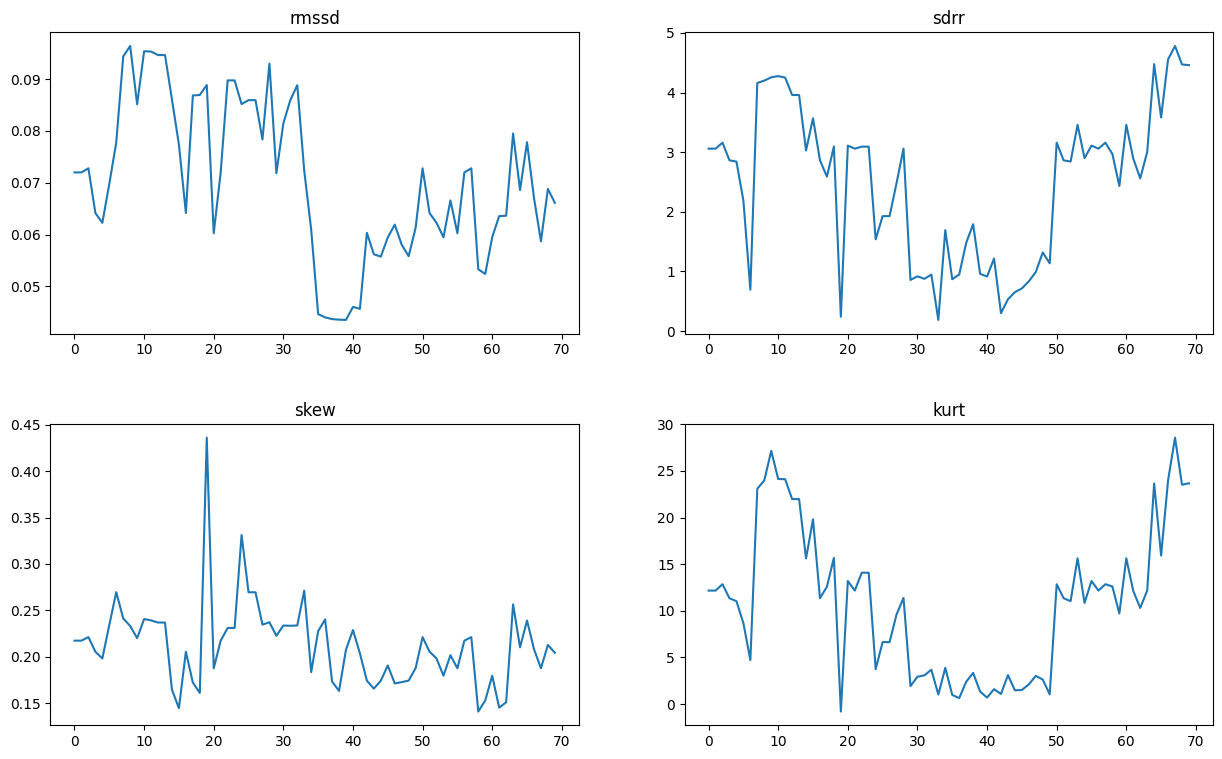

In [70]:
fig, axarr = plt.subplots(2, 2, figsize=(15, 9))
extract_frame['rmssd'][:70].plot(ax=axarr[0][0])
extract_frame['sdrr'][:70].plot(ax=axarr[1][0])
extract_frame['skew'][:70].plot(ax=axarr[0][1])
extract_frame['kurt'][:70].plot(ax=axarr[1][1])
axarr[0][0].set_title("rmssd")
axarr[0][1].set_title("sdrr")
axarr[1][0].set_title("skew")
axarr[1][1].set_title("kurt")
plt.subplots_adjust(hspace=.3)

In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier


dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=12)
dt_model = dt_model.fit(train_x, train_y)
dt_pred_y = dt_model.predict(test_x)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)
rfpred_y = rf_model.predict(test_x)

**Decision Tree**

In [72]:
print(classification_report(test_y,dt_pred_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.18      0.43      0.25         7
           2       0.54      0.50      0.52        14
           3       0.42      0.39      0.41        33
           4       0.39      0.36      0.38        25
           5       0.11      0.07      0.09        14
           6       0.00      0.00      0.00        11
           7       0.20      0.17      0.18         6

    accuracy                           0.28       120
   macro avg       0.23      0.24      0.23       120
weighted avg       0.29      0.28      0.28       120



**Random Forest**

In [73]:
print(classification_report(test_y,rfpred_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.20      0.43      0.27         7
           2       0.60      0.43      0.50        14
           3       0.45      0.52      0.48        33
           4       0.43      0.48      0.45        25
           5       0.22      0.14      0.17        14
           6       0.08      0.09      0.09        11
           7       0.33      0.17      0.22         6

    accuracy                           0.35       120
   macro avg       0.29      0.28      0.27       120
weighted avg       0.34      0.35      0.34       120



# ADDITIONAL - Other Models (LogisticRegression, SVC, KNN, VC, XGB), Balancing Data (SMOTE), and Hyperparameter Tuning (Stratified K-Fold for the validator)
- In the first stage, predictions will be made using raw data against other models
- In the second stage, predictions will be made using SMOTE data against all non-deeplearning models used
- In the third/final stage, predictions will be made using SMOTE data using non-deeplearning models that have undergone hyperparameter tuning (with the help of the Stratified K-Fold validator) for selected models

## Non-Deep Learning

In [74]:
# TAMBAHAN

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

lr_model = LogisticRegression(
    #penalty='l1',
    C=0.1,
    solver='lbfgs', 
    max_iter=10000
)

lr_model.fit(train_x, train_y)
lr_pred_y = lr_model.predict(test_x)


svc_model = SVC()
svc_model.fit(train_x, train_y)
svc_pred_y = svc_model.predict(test_x)


knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_x, train_y)
knn_pred_y = knn_model.predict(test_x)

vclf_model = VotingClassifier(estimators=[('svm',svc_model),('knn',knn_model)], voting='hard', weights=[2,1])
vclf_model.fit(train_x, train_y)
vclf_pred_y = vclf_model.predict(test_x)


xgb_model = XGBClassifier(
    max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5
)
xgb_model.fit(train_x, train_y)
xgb_pred_y = xgb_model.predict(test_x)

C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [75]:
print("lr")
print(classification_report(test_y,lr_pred_y), "\n")

print("svc")
print(classification_report(test_y,svc_pred_y), "\n")

print("knn")
print(classification_report(test_y,knn_pred_y), "\n")

print("vclf")
print(classification_report(test_y,vclf_pred_y), "\n")

print("xgb")
print(classification_report(test_y,vclf_pred_y), "\n")

lr
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        14
           3       0.28      0.76      0.41        33
           4       0.36      0.32      0.34        25
           5       0.00      0.00      0.00        14
           6       0.50      0.09      0.15        11
           7       0.12      0.17      0.14         6

    accuracy                           0.29       120
   macro avg       0.16      0.17      0.13       120
weighted avg       0.21      0.29      0.21       120
 

svc
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        14
           3       0.28      1.00      0.44        33
           4       1.00      0.08      0.15        25
           5   

C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

emotion
3    79
4    59
1    27
6    27
2    24
7    23
5    22
0    18
Name: count, dtype: int64

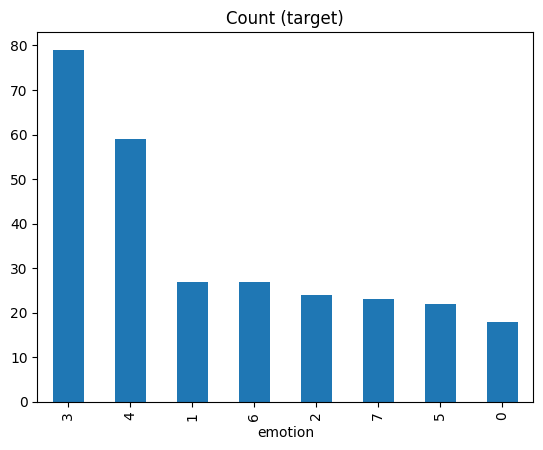

In [76]:
train_y.value_counts().plot(kind='bar', title='Count (target)');
train_y.value_counts()

### SMOTE

emotion
3    79
0    79
4    59
6    27
1    27
2    24
7    23
5    22
Name: count, dtype: int64

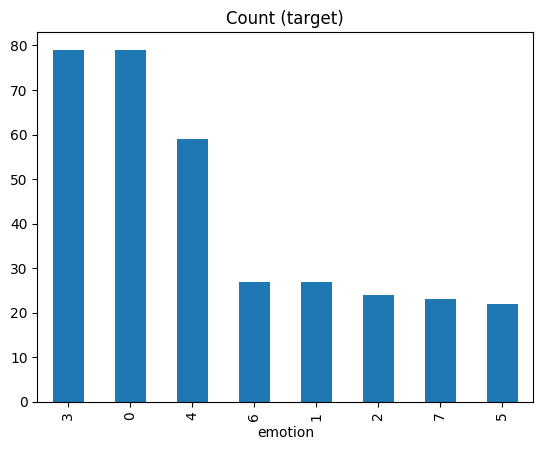

In [78]:
#  SMOTE - BALANCING DATA non-Deep Learning

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
smote_X, smote_y = smote.fit_resample(train_x, train_y)

smote_y.value_counts().plot(kind='bar', title='Count (target)');
smote_y.value_counts()

In [79]:
print("Jumlah data baru : ")
smote_y.count()-train_y.count()

Jumlah data baru : 


np.int64(61)

In [80]:
# membuat array models berisikan model yang akan digunakan untuk tahap kedua (SMOTE) dan ketiga (Hyperparameter Tuning)
models = [
    DecisionTreeClassifier(criterion="entropy", max_depth=12),
    RandomForestClassifier(),
    LogisticRegression(
        #penalty='l1',
        C=0.1,
        solver='lbfgs', 
        max_iter=10000
    ),
    SVC(),
    KNeighborsClassifier(n_neighbors=25),
    XGBClassifier(max_depth=2, gamma=2, eta=0.8, reg_alpha=0.5, reg_lambda=0.5),
]
voting_classifier = VotingClassifier(estimators=[('model_'+str(i), models[i]) for i in range(len(models))], voting='hard')
models.append(voting_classifier)

### get_metrics_summary function (gets a summary of the overall performance of the model)

function to get an initial picture of the model performance with the stratified k-fold strategy (scoring using accuracy), as well as the model performance on test data

### Hyperparameter Tuning (Random Forest & XGBoost)

In [83]:
# Hyperparameter Tuning (HT)

# import library
from sklearn.model_selection import RandomizedSearchCV

#### Random Forest

In [92]:
# HT Random Forest

parameters_rf = {
    'n_estimators' : [50, 100, 150, 200, 250, 300, 350, 400, 450, 550, 650, 750, 850, 950, 1000],
    'criterion'         : ['gini', 'entropy'],
    'max_features'      : ['sqrt','log2',0.2,0.5,0.8],
    'max_depth'         : [3,4,6,10],
    'min_samples_split' : [2, 5, 20,50]
}

rf_ht = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = parameters_rf, cv = skf, n_iter = 10,
                           scoring = 'accuracy', verbose = 5, return_train_score = True, random_state = 0)
rf_ht.fit(smote_X, smote_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=entropy, max_depth=4, max_features=0.2, min_samples_split=20, n_estimators=200;, score=(train=0.485, test=0.324) total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=4, max_features=0.2, min_samples_split=20, n_estimators=200;, score=(train=0.467, test=0.397) total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=4, max_features=0.2, min_samples_split=20, n_estimators=200;, score=(train=0.507, test=0.412) total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=4, max_features=0.2, min_samples_split=20, n_estimators=200;, score=(train=0.507, test=0.368) total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=4, max_features=0.2, min_samples_split=20, n_estimators=200;, score=(train=0.507, test=0.368) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=6, max_features=0.5, min_samples_split=50, n_estimators=650;, score=(train=0.493, test=0.338) total time=   0.4s
[CV 2/5] END

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 4, 6, 10],
                                        'max_features': ['sqrt', 'log2', 0.2,
                                                         0.5, 0.8],
                                        'min_samples_split': [2, 5, 20, 50],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         550, 650, 750, 850,
                                                         950, 1000]},
                   random_state=0, return_train_score=True, scoring='accuracy',
                   verbose=5)

In [85]:
y_rf_ht = rf_ht.predict(test_x)
print(rf_ht.best_params_)
print(classification_report(test_y, y_rf_ht))
print(rf_ht.score(smote_X, smote_y), rf_ht.score(test_x, test_y))


{'n_estimators': 950, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.14      0.40      0.21        10
           1       0.25      0.29      0.27         7
           2       0.75      0.43      0.55        14
           3       0.39      0.48      0.43        33
           4       0.46      0.48      0.47        25
           5       0.00      0.00      0.00        14
           6       0.00      0.00      0.00        11
           7       0.20      0.17      0.18         6

    accuracy                           0.34       120
   macro avg       0.27      0.28      0.26       120
weighted avg       0.33      0.34      0.32       120

0.6941176470588235 0.3416666666666667


##### Feature Importance Random Forest

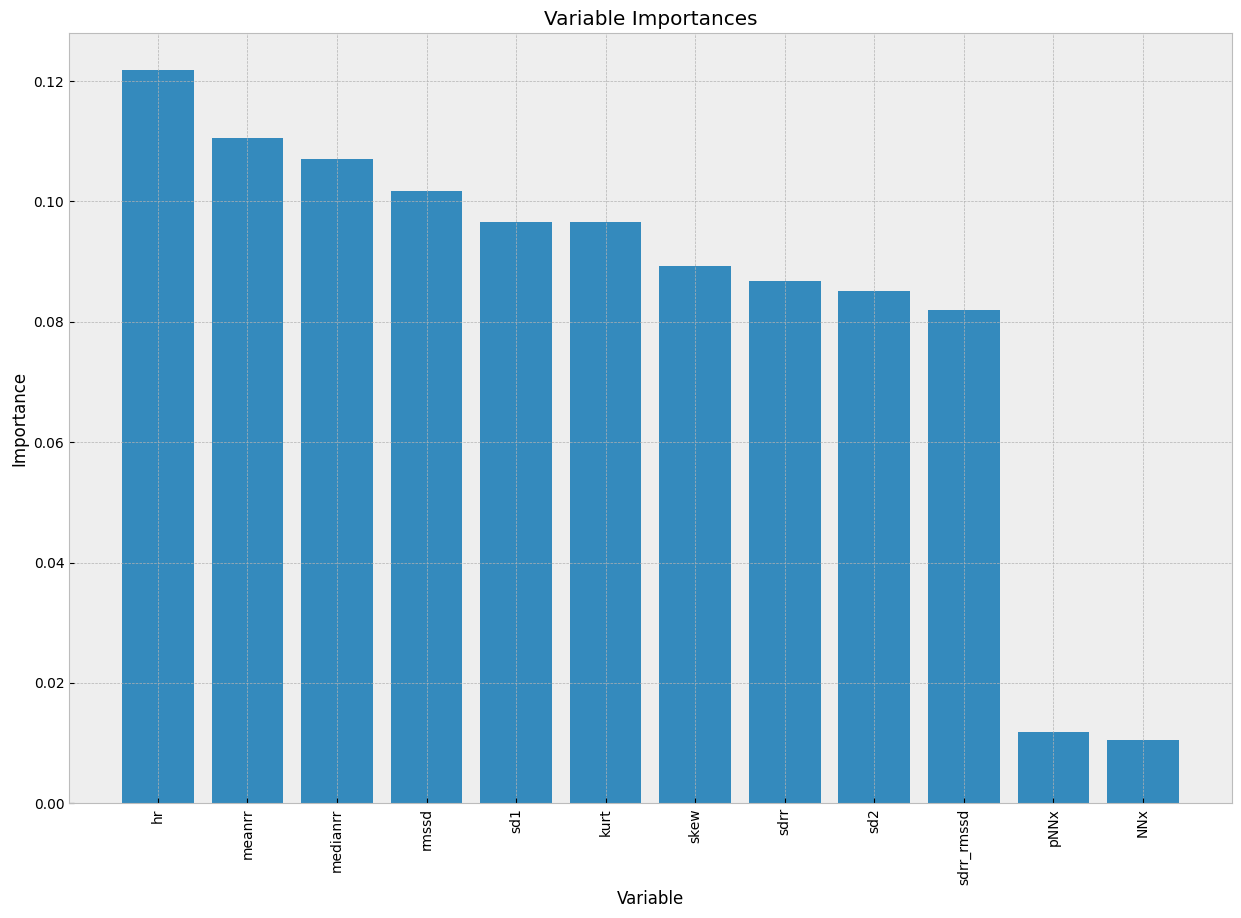

In [86]:
# Feature Importance dari RandomForest

importances = rf_ht.best_estimator_.feature_importances_
feature_list = list(smote_X.columns)
feature_importance= sorted(zip(importances, feature_list), reverse=True)

df = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
importance= list(df['importance'])
feature= list(df['feature'])

plt.style.use('bmh')
x_values = list(range(len(feature_importance)))
plt.figure(figsize=(15,10))
plt.bar(x_values, importance, orientation = 'vertical')
plt.xticks(x_values, feature, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');